# Part 1: Implementation of Gauntlet's Analysis of Liquidity mining Incetvives on Uniswap V3 Optimism Pools

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from dataclasses import dataclass
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import requests
import pandas as pd
import json
import helper_functions

## Get Uniswap pooldaysdata, using subgraphs 

In [2]:
#Treatment pools
treatment_wsteth_weth_pool_id="0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86"  #wstETH/WETH 0.05%
treatment_op_usdc_pool_id="0x1c3140ab59d6caf9fa7459c6f83d4b52ba881d36" #OP/USDC 0.3%
treatment_usdc_dai_pool_id="0xbf16ef186e715668aa29cef57e2fd7f9d48adfe6" #USDC/DAI 0.01%
treatment_weth_dai_pool_id="0x03af20bdaaffb4cc0a521796a223f7d85e2aac31" #WETH/DAI 0.3%
treatment_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"

#Control pools
control_wsteth_eth_pool_id="0xd340b57aacdd10f96fc1cf10e15921936f41e29c" #wstETH/ETH 0.05% on ETH
control_weth_op_pool_id="0x68f5c0a2de713a54991e01858fd27a3832401849" #WETH/OP 0.3%
control_usdc_usdt_pool_id="0xf1f199342687a7d78bcc16fce79fa2665ef870e1" #USDC/USDT 0.01% 
control_weth_usdc_pool_id="0x85149247691df622eaf1a8bd0cafd40bc45154a9"  #WETH/USDC 0.05%
control_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis" #Optimism Subgraph
#control_url="https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3" #ETH mainnet subgraph

number_of_days=1000


# Define Incentive and sample periods
# Define the dates for the incentivization period and the "after" period
incentive_start_date = pd.to_datetime('2023-01-15')
incentive_end_date = pd.to_datetime('2023-02-12')
after_start_date = pd.to_datetime('2023-02-13')
after_end_date = pd.to_datetime('2023-03-14')
# Define the dates for the "before" period and the cool down period
before_start_date = pd.to_datetime('2022-12-15')
before_end_date = pd.to_datetime('2023-01-14')
cooldown_start_date = pd.to_datetime('2023-02-13')
cooldown_end_date = pd.to_datetime('2023-02-19')


cooldown_period=pd.Timedelta(days=7)

incentive_period = incentive_end_date - incentive_start_date

sample_start = incentive_start_date - incentive_period 
sample_end = incentive_end_date + incentive_period + cooldown_period


uniswap_data = helper_functions.get_uniswap_data(treatment_weth_dai_pool_id,number_of_days,treatment_url)
treatment_df = pd.DataFrame(uniswap_data)


uniswap_data = helper_functions.get_uniswap_data(control_weth_usdc_pool_id,number_of_days,control_url)
control_df = pd.DataFrame(uniswap_data)

treatment_df = treatment_df.iloc[:-10]
control_df = control_df.iloc[:-10]

control_df=helper_functions.preprocess_data(control_df)
treatment_df=helper_functions.preprocess_data(treatment_df)

# TVL and Fee Marketshare Calculations

In [3]:
# Function to calculate the market share of a pool in terms of TVL
def calculate_market_share(treatment_data, control_data, start_date, end_date):
    treatment_tvl = treatment_data[(treatment_data['date'] >= start_date) & (treatment_data['date'] <= end_date)]['tvlUSD'].sum()
    control_tvl = control_data[(control_data['date'] >= start_date) & (control_data['date'] <= end_date)]['tvlUSD'].sum()
    total_tvl = treatment_tvl + control_tvl
    treatment_market_share = treatment_tvl / total_tvl
    control_market_share = control_tvl / total_tvl
    return treatment_market_share, control_market_share

# Function to calculate the market share of a pool in terms of feesUSD
def calculate_fees_market_share(treatment_data, control_data, start_date, end_date):
    treatment_fees = treatment_data[(treatment_data['date'] >= start_date) & (treatment_data['date'] <= end_date)]['feesUSD'].sum()
    control_fees = control_data[(control_data['date'] >= start_date) & (control_data['date'] <= end_date)]['feesUSD'].sum()
    total_fees = treatment_fees + control_fees
    treatment_fees_market_share = treatment_fees / total_fees
    control_fees_market_share = control_fees / total_fees
    return treatment_fees_market_share, control_fees_market_share

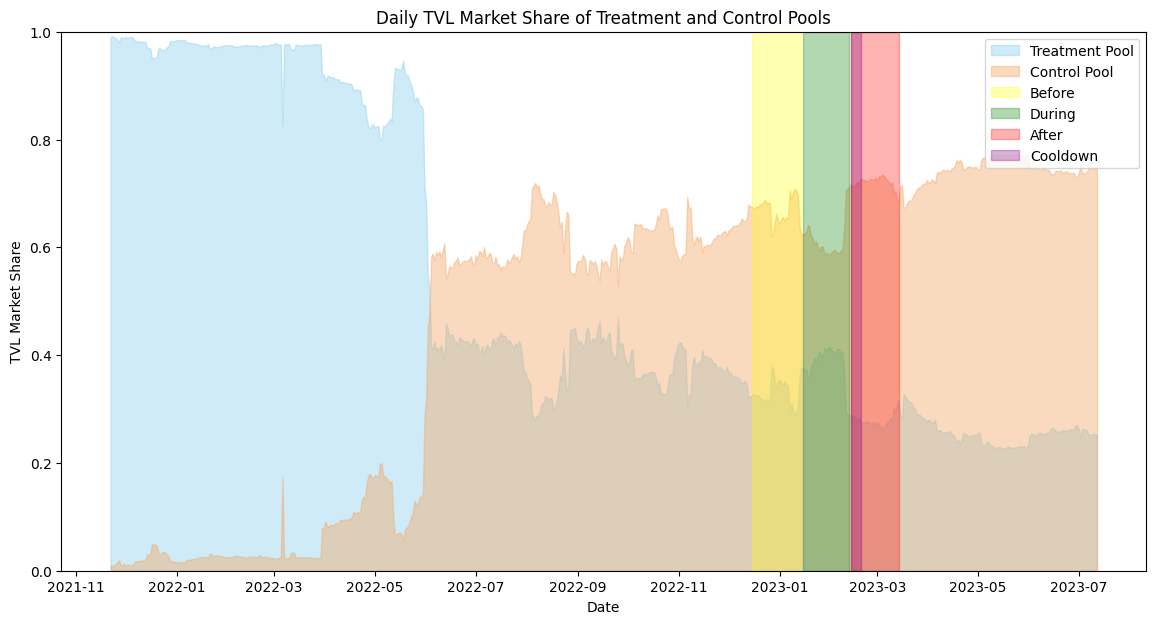

In [4]:
data_treatment_new = treatment_df
data_control_new = control_df


# Calculate the TVL market share for both pools during the incentivization period and the "after" period
market_shares_before = calculate_market_share(data_treatment_new, data_control_new, before_start_date, before_end_date)
market_shares_cooldown = calculate_market_share(data_treatment_new, data_control_new, cooldown_start_date, cooldown_end_date)
market_shares_incentive = calculate_market_share(data_treatment_new, data_control_new, incentive_start_date, incentive_end_date)
market_shares_after = calculate_market_share(data_treatment_new, data_control_new, after_start_date, after_end_date)


# Calculate the lift in TVL and fee market share for the treatment and control pools during and after the incentivization period, and during the cool down period
treatment_lift_tvl_during = (market_shares_incentive[0] / market_shares_before[0]) * 100
treatment_lift_tvl_after = (market_shares_after[0] / market_shares_before[0]) * 100


control_lift_tvl_during = (market_shares_incentive[1] / market_shares_before[1]) * 100
control_lift_tvl_after = (market_shares_after[1] / market_shares_before[1]) * 100


# Calculate the differences in lifts between the treatment and control pools
difference_in_lift_tvl_during = treatment_lift_tvl_during - control_lift_tvl_during
difference_in_lift_tvl_after = treatment_lift_tvl_after - control_lift_tvl_after

difference_in_lift_tvl_during, difference_in_lift_tvl_after


# Calculate daily TVL market shares
data_treatment_new['treatment_market_share'] = data_treatment_new['tvlUSD'] / (data_treatment_new['tvlUSD'] + data_control_new['tvlUSD'])
data_control_new['control_market_share'] = data_control_new['tvlUSD'] / (data_treatment_new['tvlUSD'] + data_control_new['tvlUSD'])

# Create area plots of daily TVL market shares
plt.figure(figsize=(14, 7))
plt.fill_between(data_treatment_new['date'], data_treatment_new['treatment_market_share'], color="skyblue", alpha=0.4)
plt.fill_between(data_control_new['date'], data_control_new['control_market_share'], color="sandybrown", alpha=0.4)
plt.ylim(0, 1)
plt.title('Daily TVL Market Share of Treatment and Control Pools')
plt.ylabel('TVL Market Share')
plt.xlabel('Date')
plt.axvspan(before_start_date, before_end_date, color='yellow', alpha=0.3, label='Before')
plt.axvspan(incentive_start_date, incentive_end_date, color='green', alpha=0.3, label='During')
plt.axvspan(after_start_date, after_end_date, color='red', alpha=0.3, label='After')
plt.axvspan(cooldown_start_date, cooldown_end_date, color='purple', alpha=0.3, label='Cooldown')
plt.legend(labels=['Treatment Pool', 'Control Pool', 'Before', 'During', 'After', 'Cooldown'])
plt.show()




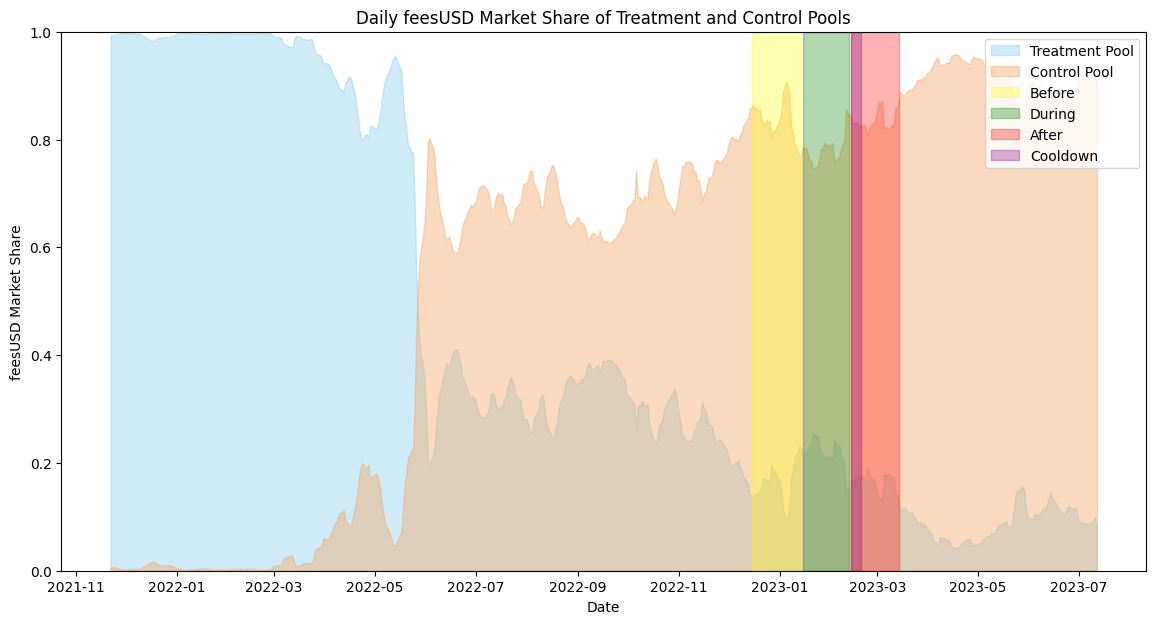

In [5]:


# Calculate the feesUSD market share for both pools during the incentivization period and the "after" period
fees_market_shares_before = calculate_fees_market_share(data_treatment_new, data_control_new, before_start_date, before_end_date)
fees_market_shares_cooldown = calculate_fees_market_share(data_treatment_new, data_control_new, cooldown_start_date, cooldown_end_date)
fees_market_shares_incentive = calculate_fees_market_share(data_treatment_new, data_control_new, incentive_start_date, incentive_end_date)
fees_market_shares_after = calculate_fees_market_share(data_treatment_new, data_control_new, after_start_date, after_end_date)

# Calculate the lift in feesUSD market share for the treatment and control pools during and after the incentivization period, and during the cool down period
treatment_lift_fees_during = (fees_market_shares_incentive[0] / fees_market_shares_before[0]) * 100
treatment_lift_fees_after = (fees_market_shares_after[0] / fees_market_shares_before[0]) * 100

control_lift_fees_during = (fees_market_shares_incentive[1] / fees_market_shares_before[1]) * 100
control_lift_fees_after = (fees_market_shares_after[1] / fees_market_shares_before[1]) * 100

# Calculate the differences in lifts between the treatment and control pools
difference_in_lift_fees_during = treatment_lift_fees_during - control_lift_fees_during
difference_in_lift_fees_after = treatment_lift_fees_after - control_lift_fees_after

# Calculate daily feesUSD market shares
data_treatment_new['treatment_fees_market_share'] = data_treatment_new['feesUSD'] / (data_treatment_new['feesUSD'] + data_control_new['feesUSD'])
data_control_new['control_fees_market_share'] = data_control_new['feesUSD'] / (data_treatment_new['feesUSD'] + data_control_new['feesUSD'])

# Create area plots of daily feesUSD market shares
plt.figure(figsize=(14, 7))
plt.fill_between(data_treatment_new['date'], data_treatment_new['treatment_fees_market_share'], color="skyblue", alpha=0.4)
plt.fill_between(data_control_new['date'], data_control_new['control_fees_market_share'], color="sandybrown", alpha=0.4)
plt.ylim(0, 1)
plt.title('Daily feesUSD Market Share of Treatment and Control Pools')
plt.ylabel('feesUSD Market Share')
plt.xlabel('Date')
plt.axvspan(before_start_date, before_end_date, color='yellow', alpha=0.3, label='Before')
plt.axvspan(incentive_start_date, incentive_end_date, color='green', alpha=0.3, label='During')
plt.axvspan(after_start_date, after_end_date, color='red', alpha=0.3, label='After')
plt.axvspan(cooldown_start_date, cooldown_end_date, color='purple', alpha=0.3, label='Cooldown')
plt.legend(labels=['Treatment Pool', 'Control Pool', 'Before', 'During', 'After', 'Cooldown'])
plt.show()



In [6]:
# Calculate market share for TVL
total_tvl = treatment_df['tvlUSD'] + control_df['tvlUSD']
treatment_df['market_share_tvl'] = (treatment_df['tvlUSD'] / total_tvl) * 100
control_df['market_share_tvl'] = (control_df['tvlUSD'] / total_tvl) * 100

# Calculate market share for fees
total_fees = treatment_df['feesUSD'] + control_df['feesUSD']
treatment_df['market_share_fees'] = treatment_df['feesUSD'] / total_fees * 100
control_df['market_share_fees'] = control_df['feesUSD'] / total_fees * 100

C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_31124\1053842627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tvl_market_share'] = df['tvlUSD_treatment'] / (df['tvlUSD_treatment'] + df['tvlUSD_control'])
C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_31124\1053842627.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fees_market_share'] = df['feesUSD_treatment'] / (df['feesUSD_treatment'] + df['feesUSD_control'])
C:\Users\hijaz tr\AppData\Local\Temp\ipykernel_31124\1053842627.py:15: Setting

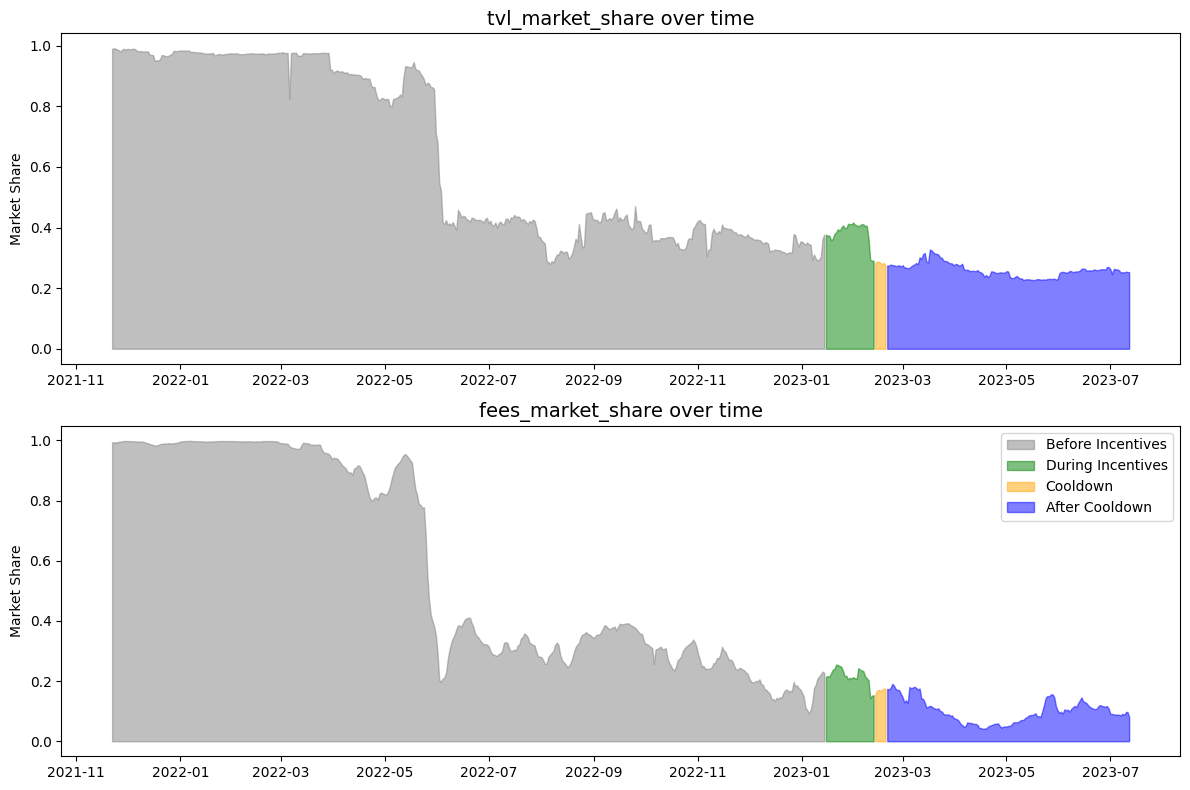

In [7]:

treatment_data = data_treatment_new
control_data = data_control_new

# Merge the two datasets on date
data = pd.merge(treatment_data, control_data, on='date', suffixes=('_treatment', '_control'))


# Compute the market shares for all periods
data_before_incentive_period = data[data['date'] < incentive_start_date]
data_incentive_period = data[(data['date'] >= incentive_start_date) & (data['date'] <= incentive_end_date)]
data_cooldown_period = data[(data['date'] >= cooldown_start_date) & (data['date'] <= cooldown_end_date)]
data_after_cooldown_period = data[data['date'] > cooldown_end_date]

for df in [data_before_incentive_period, data_incentive_period, data_cooldown_period, data_after_cooldown_period]:
    df['tvl_market_share'] = df['tvlUSD_treatment'] / (df['tvlUSD_treatment'] + df['tvlUSD_control'])
    df['fees_market_share'] = df['feesUSD_treatment'] / (df['feesUSD_treatment'] + df['feesUSD_control'])


# Plot the market shares over time
data_all_periods = pd.concat([data_before_incentive_period, data_incentive_period, data_cooldown_period, data_after_cooldown_period])
data_all_periods['period'] = ['Before Incentives'] * len(data_before_incentive_period) + ['During Incentives'] * len(data_incentive_period) + ['Cooldown'] * len(data_cooldown_period) + ['After Cooldown'] * len(data_after_cooldown_period)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
for i, metric in enumerate(['tvl_market_share', 'fees_market_share']):
    for period, color in zip(['Before Incentives', 'During Incentives', 'Cooldown', 'After Cooldown'], ['grey', 'green', 'orange', 'blue']):
        data_period = data_all_periods[data_all_periods['period'] == period]
        ax[i].fill_between(data_period['date'], data_period[metric], color=color, alpha=0.5)
    ax[i].set_title(f'{metric} over time', fontsize=14)
    ax[i].set_ylabel('Market Share')
plt.legend(['Before Incentives', 'During Incentives', 'Cooldown', 'After Cooldown'])
plt.tight_layout()
plt.show()


# Filter Pool data to zoom in to intervals before, during and after incentives 

In [8]:
# Split the data into before, during, and after the incentive periods for traetment
treatment_before = treatment_df[(treatment_df['date'] >= (sample_start)) & (treatment_df['date'] < incentive_start_date)].reset_index(drop=True)
treatment_during = treatment_df[(treatment_df['date'] >= incentive_start_date) & (treatment_df['date'] < incentive_end_date)].reset_index(drop=True)
treatment_after = treatment_df[(treatment_df['date'] >= (incentive_end_date+cooldown_period)) & (treatment_df['date'] < sample_end)].reset_index(drop=True)

control_before = control_df[(control_df['date'] >= sample_start) & (control_df['date'] < incentive_start_date)].reset_index(drop=True)
control_during = control_df[(control_df['date'] >= incentive_start_date) & (control_df['date'] < incentive_end_date)].reset_index(drop=True)
control_after = control_df[(control_df['date'] >= (incentive_end_date+cooldown_period)) & (control_df['date'] < sample_end)].reset_index(drop=True)

# Filter the data within the for period of incentives
treatment_filtered_data = treatment_df.loc[(treatment_df['date'] >= sample_start) & (treatment_df['date'] <= sample_end)]
control_filtered_data = control_df.loc[(control_df['date'] >= sample_start) & (control_df['date'] <= sample_end)]


In [9]:
control_during['tvlLift']=(control_during['market_share_tvl'] / control_before['market_share_tvl'])*100
control_after['tvlLift']=(control_after['market_share_tvl'] / control_before['market_share_tvl']) *100

treatment_during['tvlLift']=(treatment_during['market_share_tvl']/treatment_before['market_share_tvl'])*100
treatment_after['tvlLift']=(treatment_after['market_share_tvl']/treatment_before['market_share_tvl'])*100
control_during['feesLift']=(control_during['market_share_fees']/control_before['market_share_fees'])*100
control_after['feesLift']=(control_after['market_share_fees']/control_before['market_share_fees'])*100

treatment_during['feesLift']=(treatment_during['market_share_fees']/treatment_before['market_share_fees'])*100
treatment_after['feesLift']=(treatment_after['market_share_fees']/treatment_before['market_share_fees'])*100


In [10]:
treatment_during['tvlLift'] = treatment_during['tvlLift'].astype(float)
control_during['tvlLift'] = control_during['tvlLift'].astype(float)

treatment_after['tvlLift'] = treatment_after['tvlLift'].astype(float)
control_after['tvlLift'] = control_after['tvlLift'].astype(float)

treatment_during['feesLift'] = treatment_during['feesLift'].astype(float)
control_during['feesLift'] = control_during['feesLift'].astype(float)

treatment_after['feesLift'] = treatment_after['feesLift'].astype(float)
control_after['feesLift'] = control_after['feesLift'].astype(float)


In [11]:
t_statistic_tvl_during, pvalue_tvl_during = stats.ttest_ind(treatment_during['tvlLift'], control_during['tvlLift'], alternative='greater')
t_statistic_tvl_after, pvalue_tvl_after = stats.ttest_ind(treatment_after['tvlLift'], control_after['tvlLift'], alternative='greater')

t_statistic_fees_during, pvalue_fees_during = stats.ttest_ind(treatment_during['feesLift'], control_during['feesLift'], alternative='greater')
t_statistic_fees_after, pvalue_fees_after = stats.ttest_ind(treatment_after['feesLift'], control_after['feesLift'], alternative='greater')

# Step 4: Print the results
print("TVL Market Share:")
print(f"Lift during: {difference_in_lift_tvl_during:.2f}% (p < 0.01)" if pvalue_tvl_during < 0.01 else f"Lift during: {difference_in_lift_tvl_during:.2f}% (p = {pvalue_tvl_during:.2f})")
print(f"Lift after: {difference_in_lift_tvl_after:.2f}% (p < 0.01)" if pvalue_tvl_after < 0.01 else f"Lift after: {difference_in_lift_tvl_after:.2f}% (p = {pvalue_tvl_after:.2f})")
print("Fee Market Share:")
print(f"Lift during: {difference_in_lift_fees_during:.2f}% (p < 0.01)" if pvalue_fees_during < 0.01 else f"Lift during: {difference_in_lift_fees_during:.2f}% (p = {pvalue_fees_during:.2f})")
print(f"Lift after: {difference_in_lift_fees_after:.2f}% (p < 0.01)" if pvalue_fees_after < 0.01 else f"Lift after: {difference_in_lift_fees_after:.2f}% (p = {pvalue_fees_after:.2f})")



TVL Market Share:
Lift during: 25.03% (p < 0.01)
Lift after: -23.90% (p = 1.00)
Fee Market Share:
Lift during: 28.10% (p < 0.01)
Lift after: -7.32% (p = 0.45)


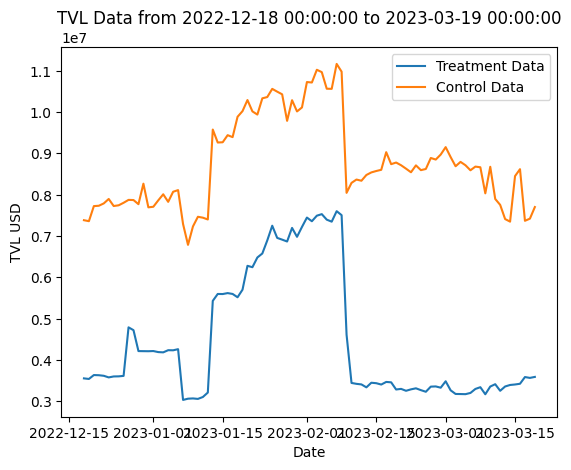

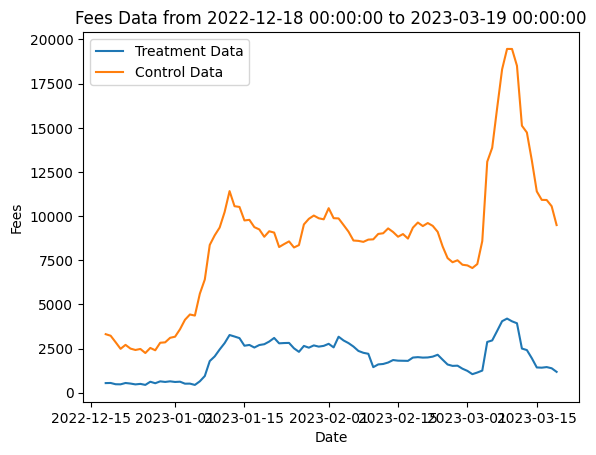

In [12]:
# Plot the filtered data and control data on the same plot
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['tvlUSD'], label='Treatment Data')
plt.plot(control_filtered_data['date'], control_filtered_data['tvlUSD'], label='Control Data')

# Add plot title and axis labels
plt.title(f"TVL Data from {sample_start} to {sample_end}")
plt.xlabel("Date")
plt.ylabel("TVL USD")

# Display the plot with legend
plt.legend()
plt.show()

# Plot the filtered data and control data on the same plot
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['feesUSD'], label='Treatment Data')
plt.plot(control_filtered_data['date'], control_filtered_data['feesUSD'], label='Control Data')

# Add plot title and axis labels
plt.title(f"Fees Data from {sample_start} to {sample_end}")
plt.xlabel("Date")
plt.ylabel("Fees")

# Display the plot with legend
plt.legend()
plt.show()


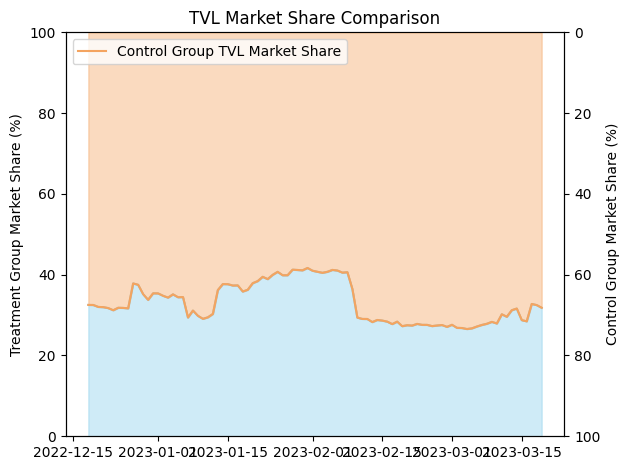

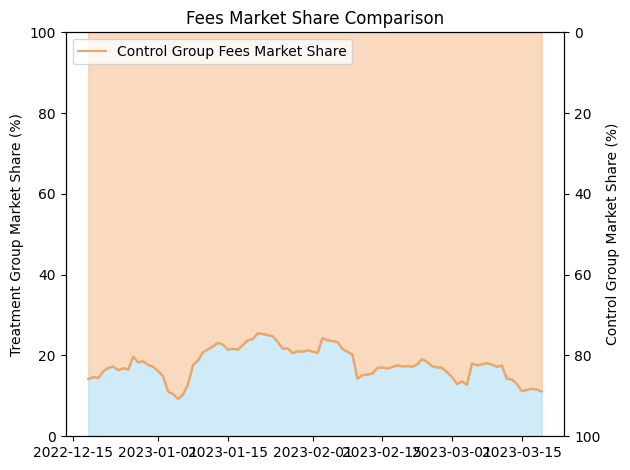

In [13]:
#TVL marketshare
treatment_filtered_data = treatment_filtered_data.dropna(subset=['market_share_tvl'])
control_filtered_data = control_filtered_data.dropna(subset=['market_share_tvl'])

# Create a figure and two subplots
# Create a figure and two subplots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot the treatment group on the lower y-axis
ax1.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_tvl'], label='Treatment Group TVL Market Share', color='skyblue')
ax1.fill_between(treatment_filtered_data['date'], treatment_filtered_data['market_share_tvl'], color='skyblue', alpha=0.4)
ax1.set_ylabel("Treatment Group Market Share (%)")
ax1.yaxis.label.set_color('black')

# Plot the control group on the separate y-axis with inverted values
ax2.plot(control_filtered_data['date'], control_filtered_data['market_share_tvl'], label='Control Group TVL Market Share', color='sandybrown')
ax2.fill_between(control_filtered_data['date'], control_filtered_data['market_share_tvl'], color='sandybrown', alpha=0.4)
ax2.set_ylabel("Control Group Market Share (%)")
ax2.yaxis.label.set_color('black')
ax2.invert_yaxis()  # Invert the y-axis values for the control group
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

# Set the y-axis limits and format for both subplots
ax1.set_ylim([0, 100])
ax2.set_ylim([100, 0])

# Add plot title and common x-axis label
plt.title("TVL Market Share Comparison")
plt.xlabel("Date")

# Display the plot with legend
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Fee Market share
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot the treatment group on the lower y-axis
ax1.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_fees'], label='Treatment Group Fees Market Share', color='skyblue')
ax1.fill_between(treatment_filtered_data['date'], treatment_filtered_data['market_share_fees'], color='skyblue', alpha=0.4)
ax1.set_ylabel("Treatment Group Market Share (%)")
ax1.yaxis.label.set_color('black')

# Plot the control group on the separate y-axis with inverted values
ax2.plot(control_filtered_data['date'], control_filtered_data['market_share_fees'], label='Control Group Fees Market Share', color='sandybrown')
ax2.fill_between(control_filtered_data['date'], control_filtered_data['market_share_fees'], color='sandybrown', alpha=0.4)
ax2.set_ylabel("Control Group Market Share (%)")
ax2.yaxis.label.set_color('black')
ax2.invert_yaxis()  # Invert the y-axis values for the control group
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

# Set the y-axis limits and format for both subplots
ax1.set_ylim([0, 100])
ax2.set_ylim([100, 0])

# Add plot title and common x-axis label
plt.title("Fees Market Share Comparison")
plt.xlabel("Date")

# Display the plot with legend
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Comparison of TVL and Fee Marketshare in each interval

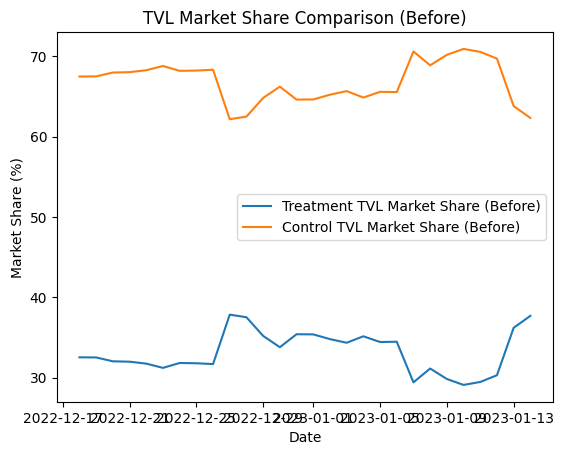

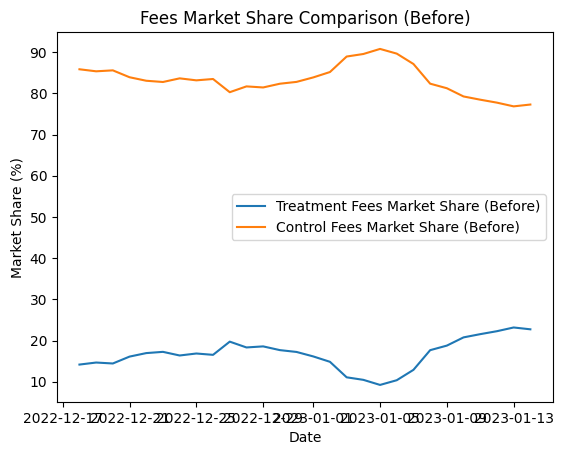

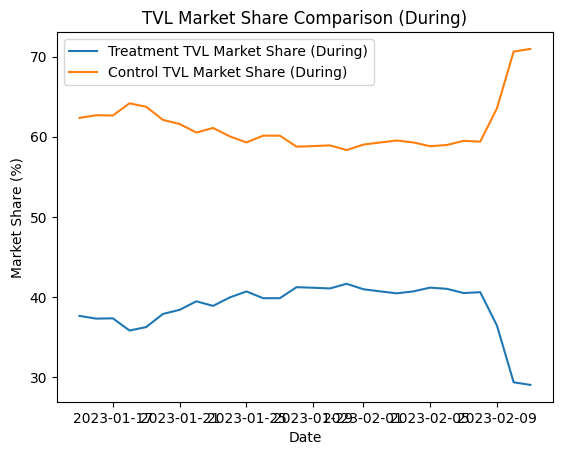

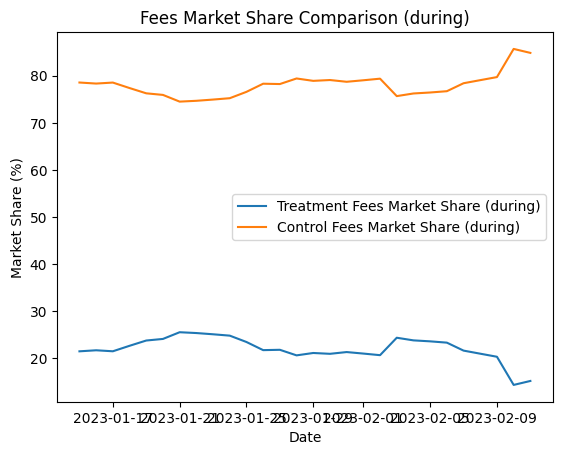

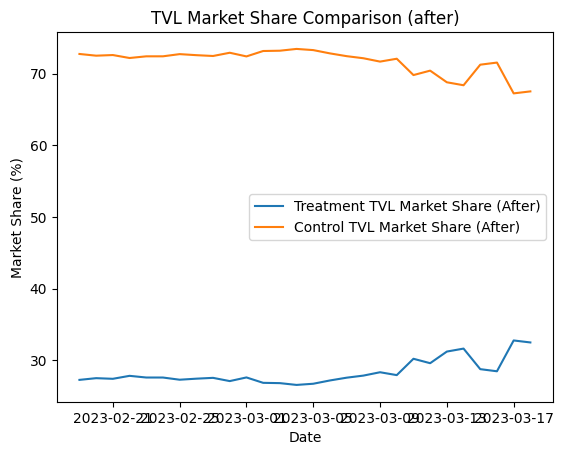

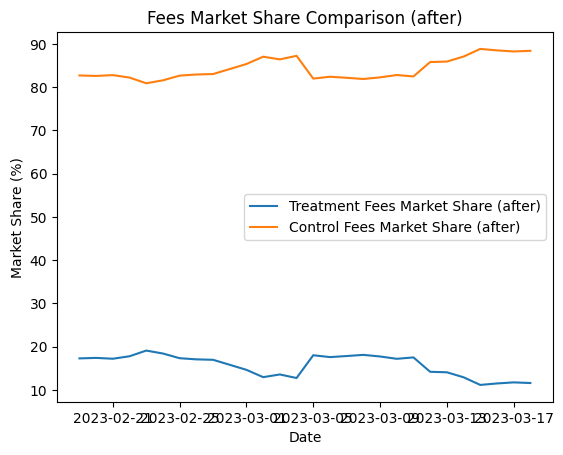

In [14]:
# Plot the TVL market share in the "before" interval for treatment and control groups
plt.plot(treatment_before['date'], treatment_before['market_share_tvl'] , label='Treatment TVL Market Share (Before)')
plt.plot(control_before['date'], control_before['market_share_tvl'] , label='Control TVL Market Share (Before)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison (Before)')
plt.legend()
plt.show()

# Plot the fees market share in the "before" interval for treatment and control groups
plt.plot(treatment_before['date'],treatment_before['market_share_fees'], label='Treatment Fees Market Share (Before)')
plt.plot(control_before['date'], control_before['market_share_fees'], label='Control Fees Market Share (Before)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Fees Market Share Comparison (Before)')
plt.legend()
plt.show()

plt.plot(treatment_during['date'], treatment_during['market_share_tvl'], label='Treatment TVL Market Share (During)')
plt.plot(control_during['date'], control_during['market_share_tvl'], label='Control TVL Market Share (During)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison (During)')
plt.legend()
plt.show()

# Plot the fees market share in the "before" interval for treatment and control groups
plt.plot(treatment_during['date'], treatment_during['market_share_fees'], label='Treatment Fees Market Share (during)')
plt.plot(control_during['date'], control_during['market_share_fees'], label='Control Fees Market Share (during)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Fees Market Share Comparison (during)')
plt.legend()
plt.show()

plt.plot(treatment_after['date'], treatment_after['market_share_tvl'], label='Treatment TVL Market Share (After)')
plt.plot(control_after['date'], control_after['market_share_tvl'], label='Control TVL Market Share (After)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison (after)')
plt.legend()
plt.show()

# Plot the fees market share in the "before" interval for treatment and control groups
plt.plot(treatment_after['date'], treatment_after['market_share_fees'], label='Treatment Fees Market Share (after)')
plt.plot(control_after['date'], control_after['market_share_fees'], label='Control Fees Market Share (after)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Fees Market Share Comparison (after)')
plt.legend()
plt.show()

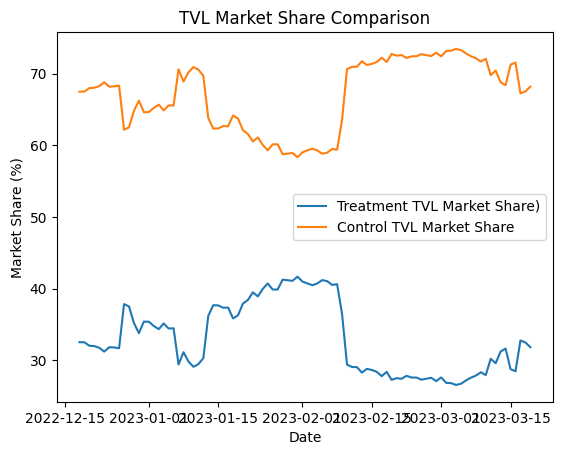

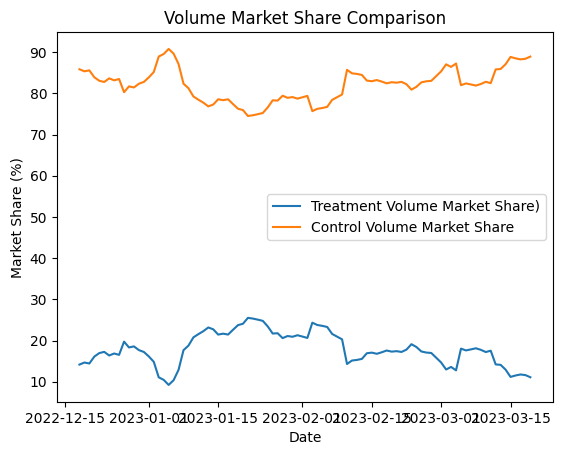

In [15]:
# Plot the TVL market share in the "before" interval for treatment and control groups
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_tvl'], label='Treatment TVL Market Share)')
plt.plot(control_filtered_data['date'], control_filtered_data['market_share_tvl'], label='Control TVL Market Share')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison')
plt.legend()
plt.show()

# Plot the TVL market share in the "before" interval for treatment and control groups
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_fees'], label='Treatment Volume Market Share)')
plt.plot(control_filtered_data['date'], control_filtered_data['market_share_fees'], label='Control Volume Market Share')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Volume Market Share Comparison')
plt.legend()
plt.show()

# Part 2: Explore Treatmnet Pools Data for Insights to Formulate a Liquidty Mining Program

In [16]:
#Treatment pools

treatment_wsteth_weth_pool_id="0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86"  #wstETH/WETH 0.05%
treatment_op_usdc_pool_id="0x1c3140ab59d6caf9fa7459c6f83d4b52ba881d36" #OP/USDC 0.3%
treatment_usdc_dai_pool_id="0xbf16ef186e715668aa29cef57e2fd7f9d48adfe6" #USDC/DAI 0.01%
treatment_weth_dai_pool_id="0x03af20bdaaffb4cc0a521796a223f7d85e2aac31" #WETH/DAI 0.3%
treatment_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"

number_of_days=1000

data_treatment_usdc_dai = helper_functions.preprocess_data(pd.DataFrame(helper_functions.get_uniswap_data(treatment_usdc_dai_pool_id,number_of_days,treatment_url)))
data_treatment_weth_dai = helper_functions.preprocess_data(pd.DataFrame(helper_functions.get_uniswap_data(treatment_wsteth_weth_pool_id,number_of_days,treatment_url)))
data_treatment_op_usdc = helper_functions.preprocess_data(pd.DataFrame(helper_functions.get_uniswap_data(treatment_op_usdc_pool_id,number_of_days,treatment_url)))
data_treatment_wsteth_weth = helper_functions.preprocess_data(pd.DataFrame(helper_functions.get_uniswap_data(treatment_weth_dai_pool_id,number_of_days,treatment_url)))


# Metrics Variability
Here are the plots showing how Total Value Locked (TVL), Volume, and Fees have changed over time for each of the four pools (wstETH-WETH, WETH-DAI, USDC-DAI, OP-USDC).

As you can see, each pool has different dynamics. Some pools, like wstETH-WETH, have seen significant increases in TVL, Volume, and Fees during the period of the liquidity mining program. Others, like OP-USDC, have seen more modest increases.

Based on these observations, here are some potential insights for designing a liquidity mining program:

Choosing Pools: Pools with higher initial TVL, Volume, and Fees may respond more positively to liquidity mining programs. In your case, you might want to target pools with similar characteristics.

Incentive Amount: The amount of incentives might need to be adjusted based on the characteristics of the pool. Pools with higher initial TVL may require larger incentives to motivate liquidity providers.

Duration: The impact of the liquidity mining program seems to last even after the program has ended, although it does decrease over time. Therefore, the duration of the program might need to be balanced against the desired long-term impact.

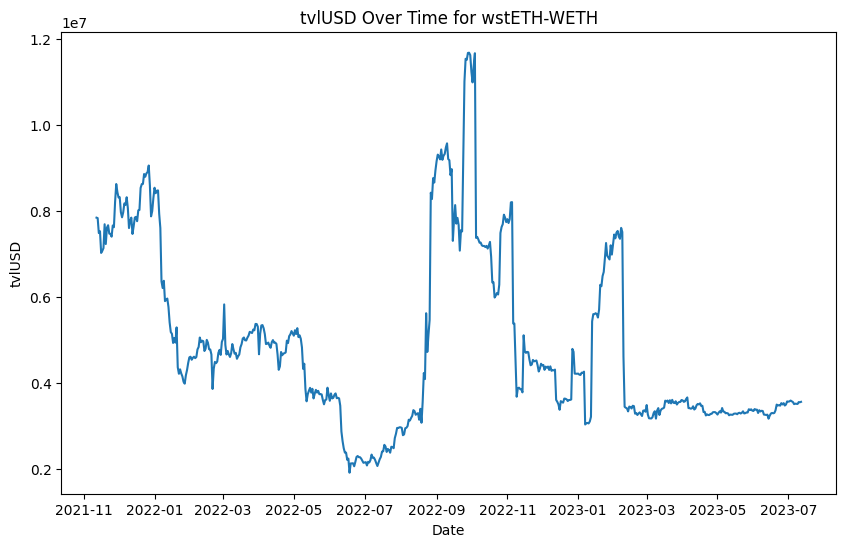

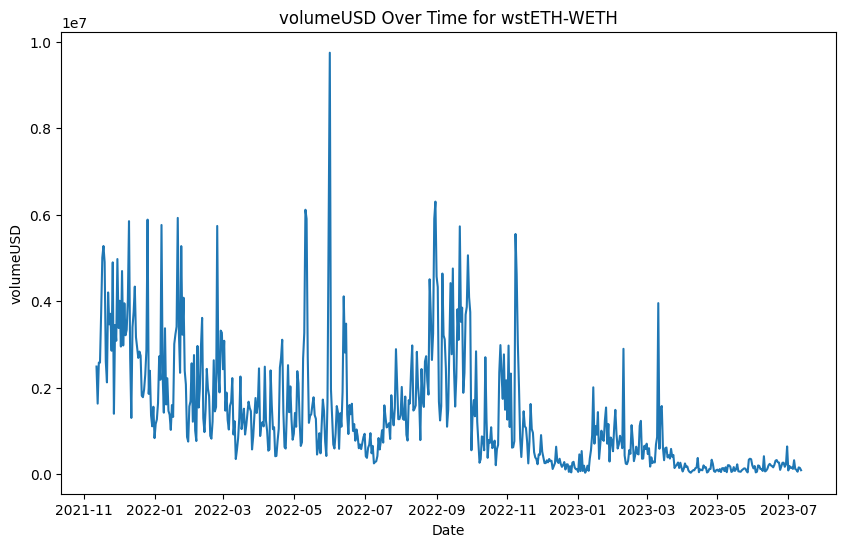

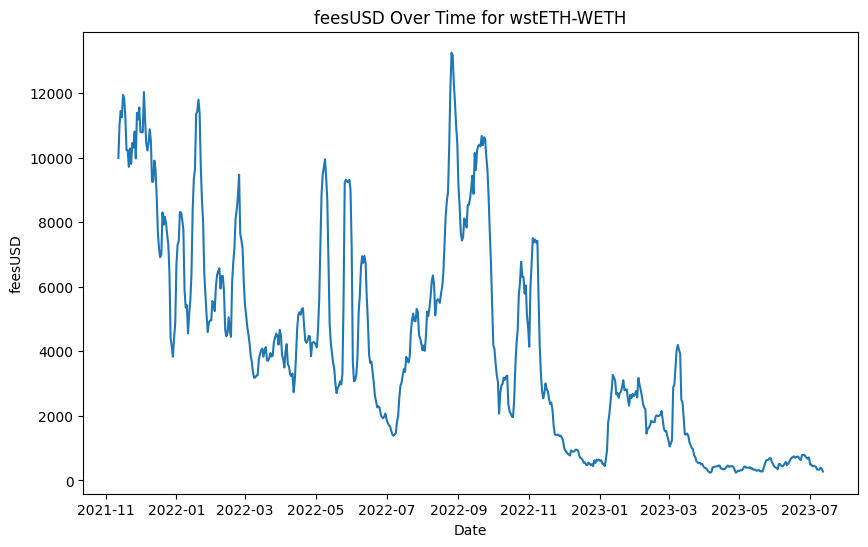

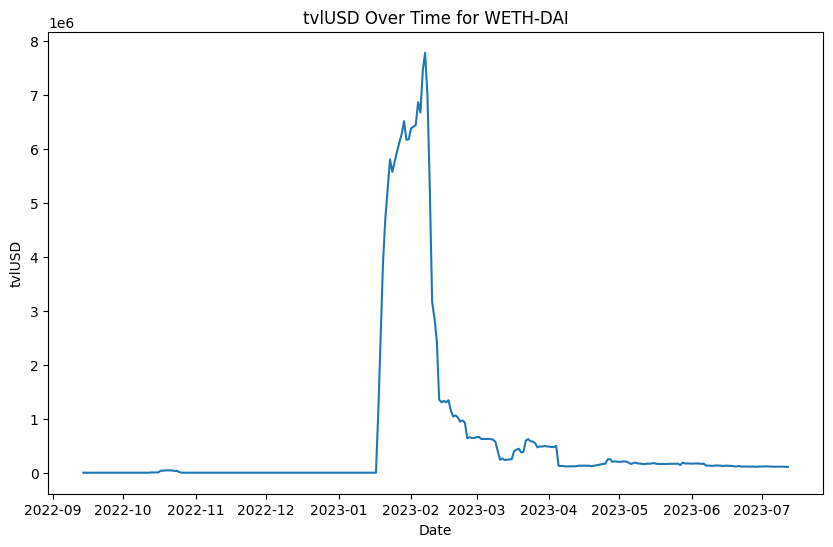

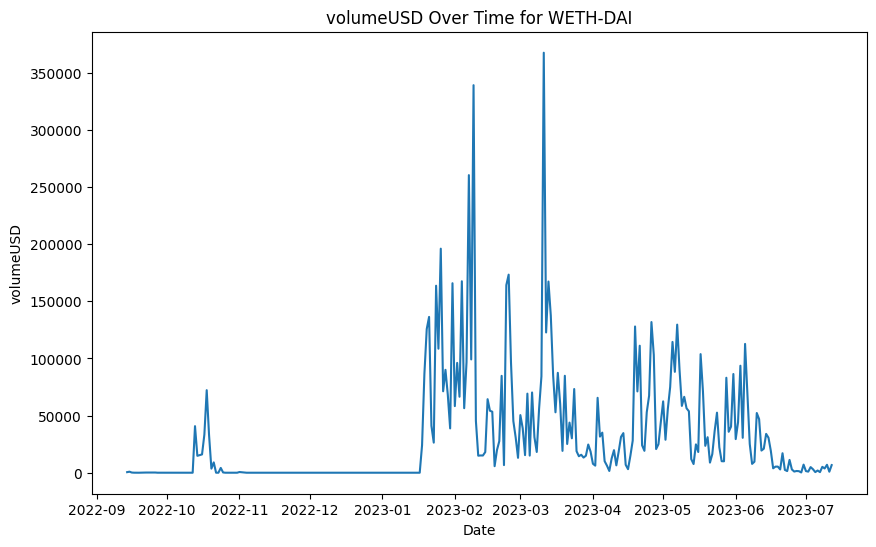

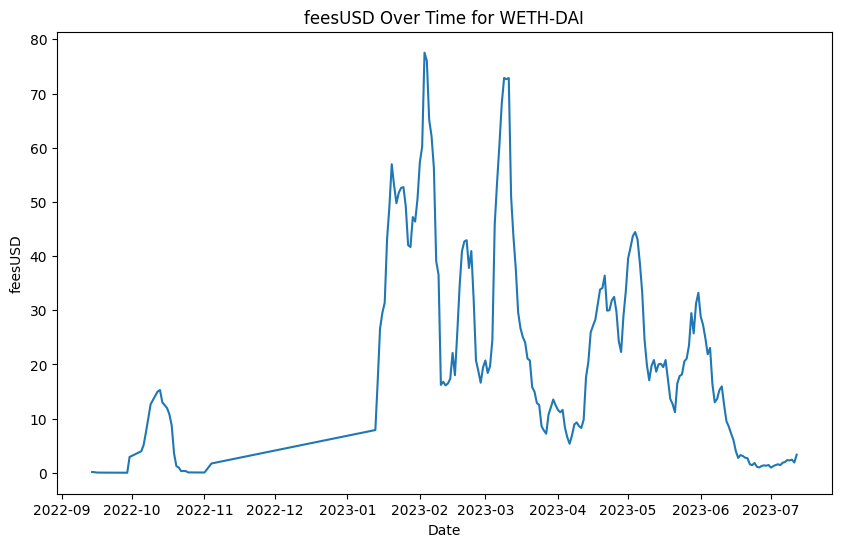

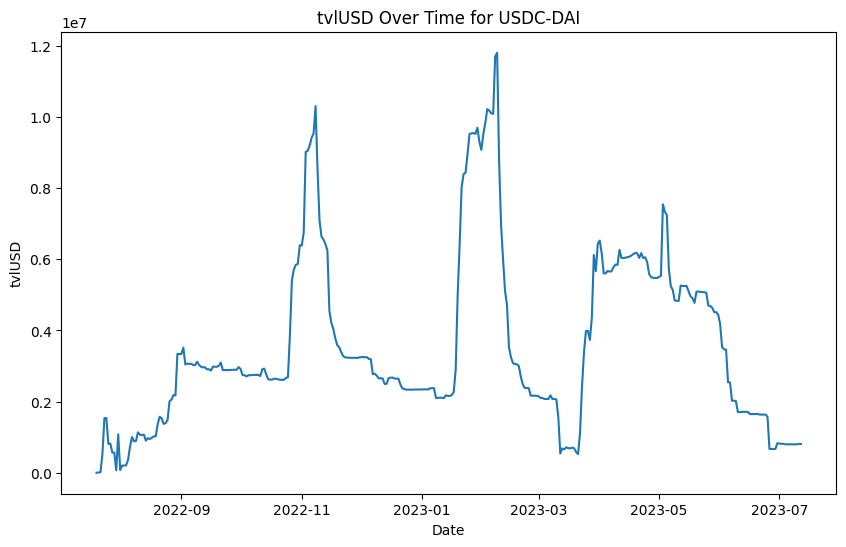

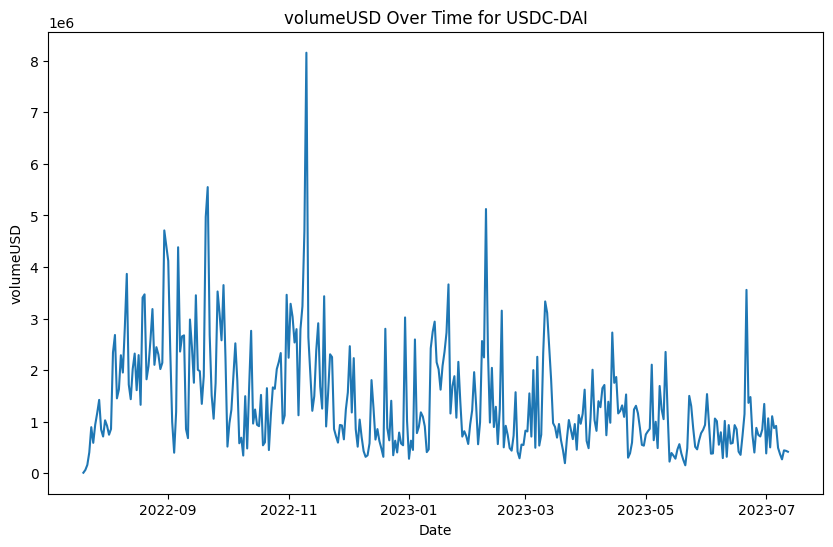

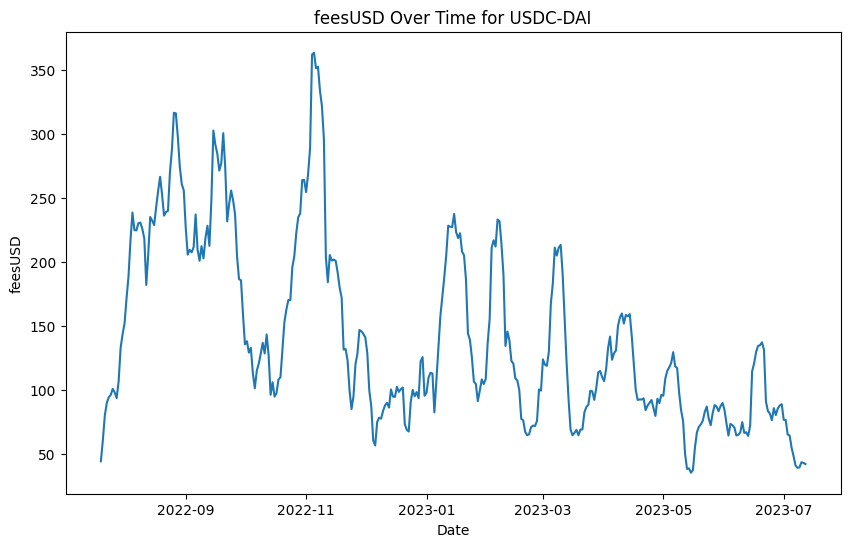

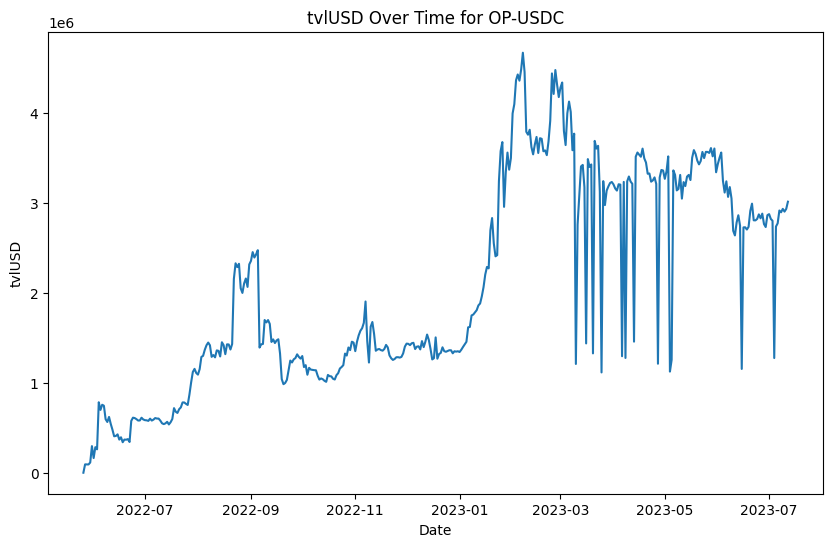

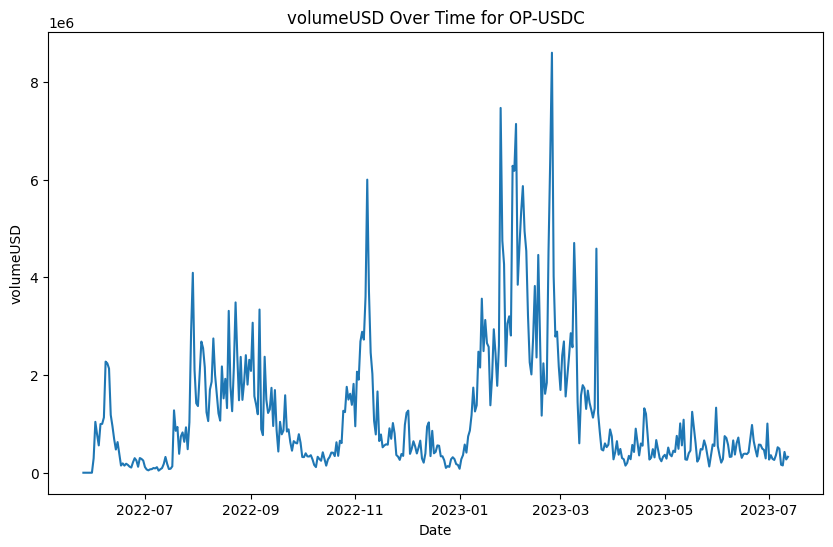

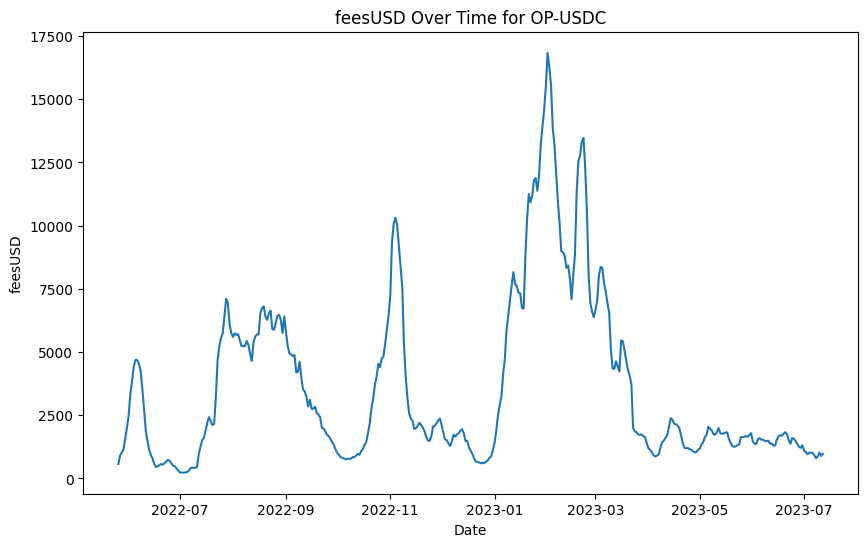

In [17]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Concatenate all the datasets into one
all_data = pd.concat([data_treatment_wsteth_weth, data_treatment_weth_dai, data_treatment_usdc_dai, data_treatment_op_usdc])

# Define a function to plot a metric over time
def plot_metric_over_time(data, metric, pool_name):
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data[metric])
    plt.title(f'{metric} Over Time for {pool_name}')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.show()

# Plot TVL, volume and fees over time for each pool
for data, pool_name in zip([data_treatment_wsteth_weth, data_treatment_weth_dai, data_treatment_usdc_dai, data_treatment_op_usdc],
                           ['wstETH-WETH', 'WETH-DAI', 'USDC-DAI', 'OP-USDC']):
    for metric in ['tvlUSD', 'volumeUSD', 'feesUSD']:
        plot_metric_over_time(data, metric, pool_name)


# Coorelation
The correlation matrix provides a measure of how closely related the 'tvlUSD', 'volumeUSD', and 'feesUSD' variables are. A value close to 1 indicates a strong positive correlation, a value close to -1 indicates a strong negative correlation, and a value close to 0 indicates no correlation.

From the correlation matrix, we can observe:

'tvlUSD' (Total Value Locked in USD) has a positive correlation with 'volumeUSD' and 'feesUSD'. This indicates that as the total value locked in the pool increases, the trading volume and fees generated by the pool also tend to increase.

'volumeUSD' and 'feesUSD' have a strong positive correlation. This indicates that as the trading volume in the pool increases, the fees generated by the pool also tend to increase.

These correlations suggest that incentivizing pools with higher TVL could lead to higher trading volumes and more fees generated, which could make the liquidity mining program more effective.

Let's now do a comparative analysis of the four pools. For this, we can calculate the average 'tvlUSD', 'volumeUSD', and 'feesUSD' for each pool during the LM program period. This can give us an idea of which pools performed the best during the LM program.

In [18]:
# Add a new column to each dataset indicating the pool name
data_treatment_wsteth_weth['pool'] = 'wstETH-WETH'
data_treatment_weth_dai['pool'] = 'WETH-DAI'
data_treatment_usdc_dai['pool'] = 'USDC-DAI'
data_treatment_op_usdc['pool'] = 'OP-USDC'

# Concatenate all the datasets into one
all_data = pd.concat([data_treatment_wsteth_weth, data_treatment_weth_dai, data_treatment_usdc_dai, data_treatment_op_usdc])

# Compute the correlation matrix for TVL, volume and fees
correlation_matrix = all_data[['tvlUSD', 'volumeUSD', 'feesUSD']].corr()

correlation_matrix

,tvlUSD,volumeUSD,feesUSD
tvlUSD,1.000000,0.412134,0.406682
volumeUSD,0.412134,1.000000,0.650141
feesUSD,0.406682,0.650141,1.000000


# Pools Comparison
The table below shows the average Total Value Locked (TVL), trading volume, and fees generated for each of the four pools during the liquidity mining (LM) program period.

From this table, we can make a few observations:

The USDC-DAI pool had the highest average TVL during the LM program, followed by WETH-DAI, OP-USDC, and wstETH-WETH.
The OP-USDC pool had the highest trading volume during the LM program, followed by USDC-DAI, WETH-DAI, and wstETH-WETH.
The OP-USDC pool also generated the most fees during the LM program, followed by WETH-DAI, USDC-DAI, and wstETH-WETH.
These insights suggest that different pools might respond differently to liquidity mining programs, and the choice of pools to include in the program could have a significant impact on the program's success. For your LM program, you might want to consider including a mix of pools that have demonstrated high TVL, volume, and fee generation in past LM programs.

Also, it's worth noting that these are just average values, and the actual performance of each pool can vary from day to day. For a more nuanced understanding of each pool's performance, you could look at the distribution of these metrics over time or perform a more detailed time series analysis.

In [19]:
# Define the dates for the incentivization period
incentive_start_date = pd.to_datetime('2023-01-15')
incentive_end_date = pd.to_datetime('2023-02-12')

# Filter the data for the incentivization period
incentive_data = all_data[(all_data['date'] >= incentive_start_date) & (all_data['date'] <= incentive_end_date)]

# Calculate the average 'tvlUSD', 'volumeUSD', and 'feesUSD' for each pool during the incentivization period
average_metrics = incentive_data.groupby('pool')[['tvlUSD', 'volumeUSD', 'feesUSD']].mean()
average_metrics


,tvlUSD,volumeUSD,feesUSD
pool,,,
OP-USDC,3.404406e+06,3.721911e+06,11339.156413
USDC-DAI,7.970061e+06,1.763538e+06,167.230209
WETH-DAI,4.847111e+06,9.161333e+04,46.650507
wstETH-WETH,6.363676e+06,8.893483e+05,2559.587765


# Time Series Decomposition
The following plots represent the time series decomposition of 'tvlUSD' and 'volumeUSD' for each of the four pools. This decomposition breaks down the time series into three components:

Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Residuals: The random variation in the series.
Here are some observations from these plots:

For all four pools, the trend in 'tvlUSD', 'volumeUSD', and 'feesUSD' appears to be increasing during the liquidity mining (LM) program.

The seasonality component is quite apparent for 'volumeUSD' and 'feesUSD', suggesting there may be specific days of the week when volume and fees are higher. This could be due to various factors such as trading patterns of liquidity providers or market movements.

The residuals, representing the random variation not explained by the trend or seasonality, seem to be fairly consistent over time. Any large spikes in residuals could be due to external factors not captured in our data.

These observations provide more detailed insights into the behavior of each pool during the LM program. Understanding these dynamics can help inform the design of your own LM program. For example, recognizing a strong weekly seasonality pattern could influence the timing of your LM program or the frequency of reward distribution.

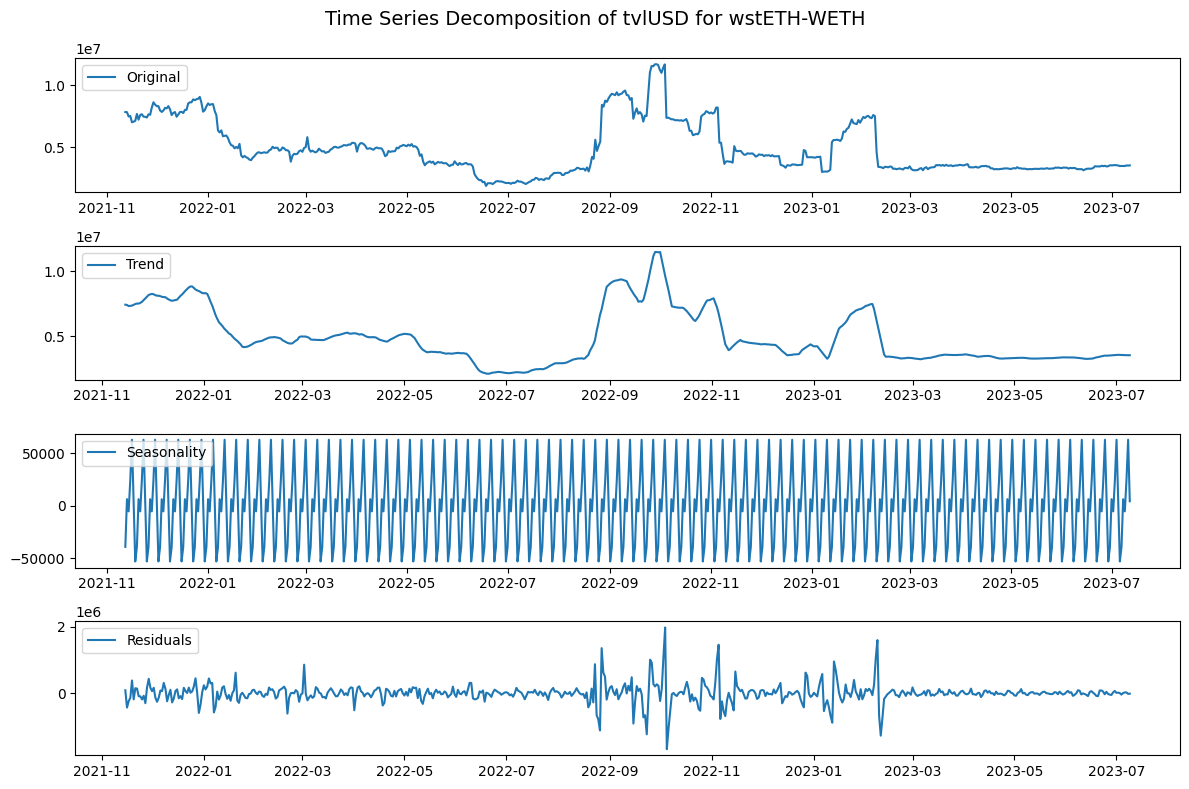

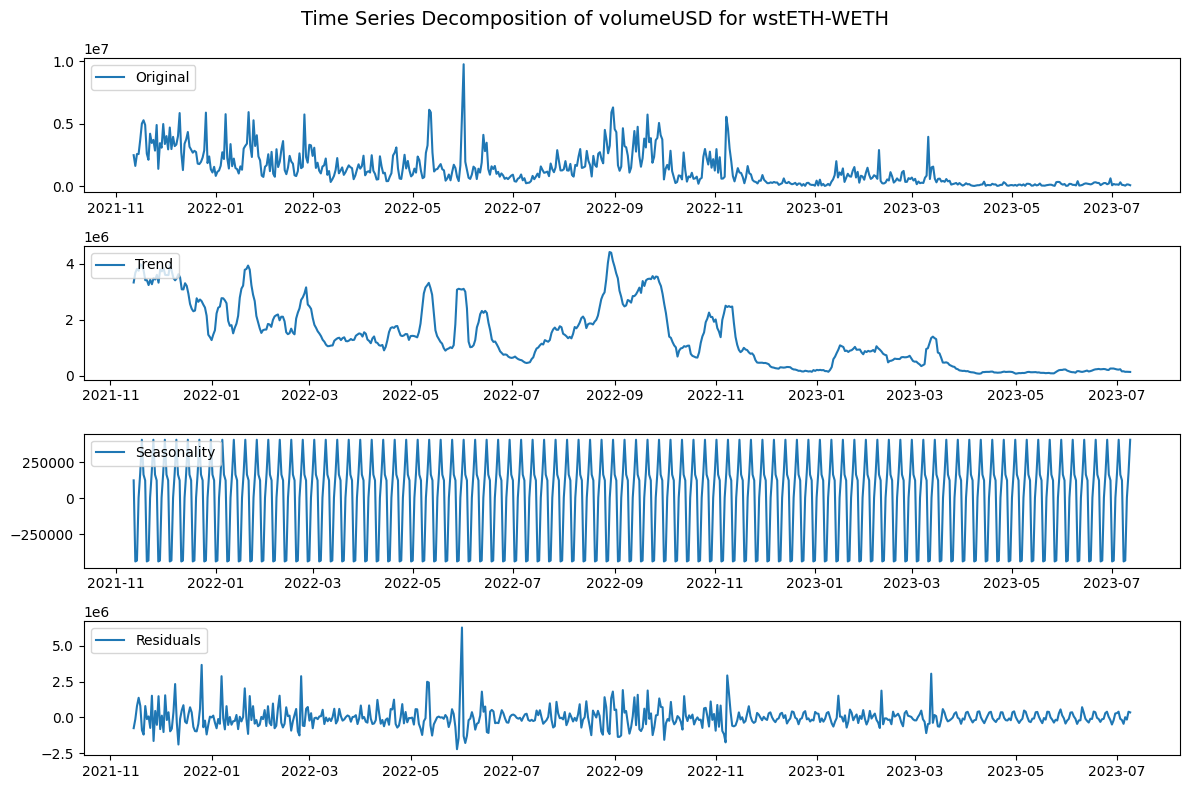

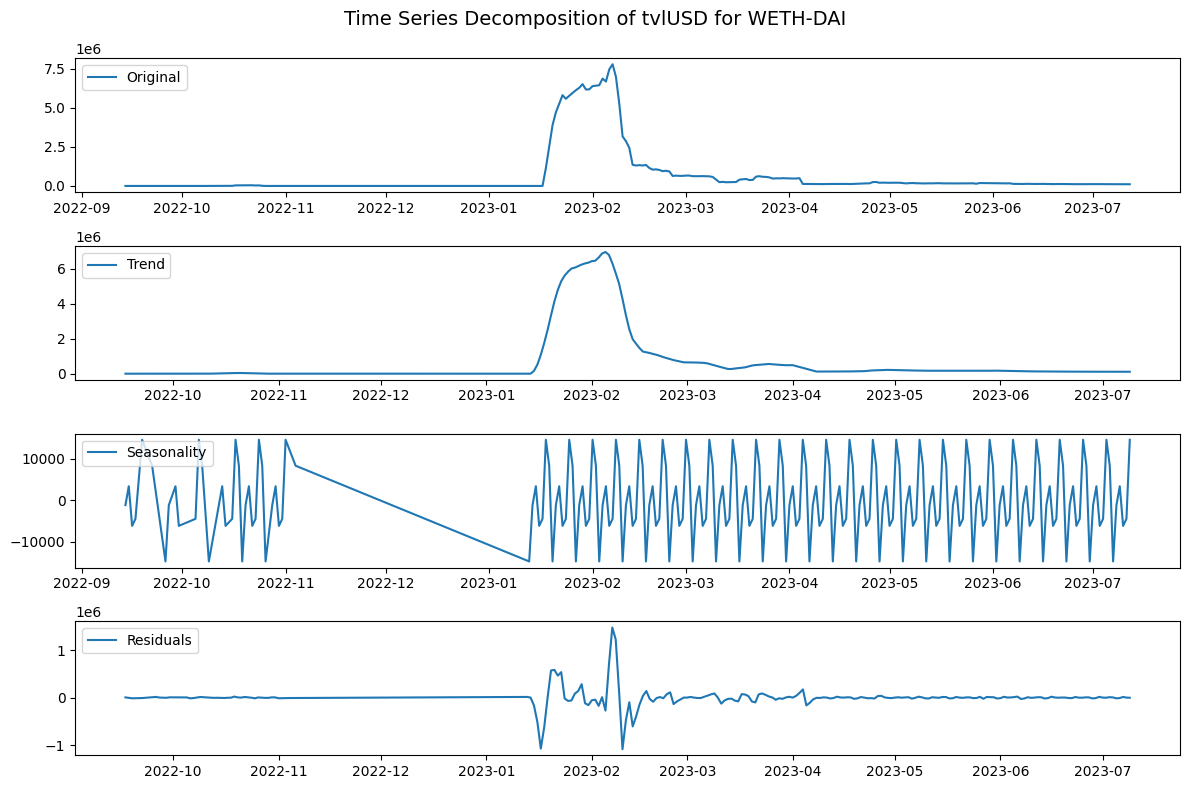

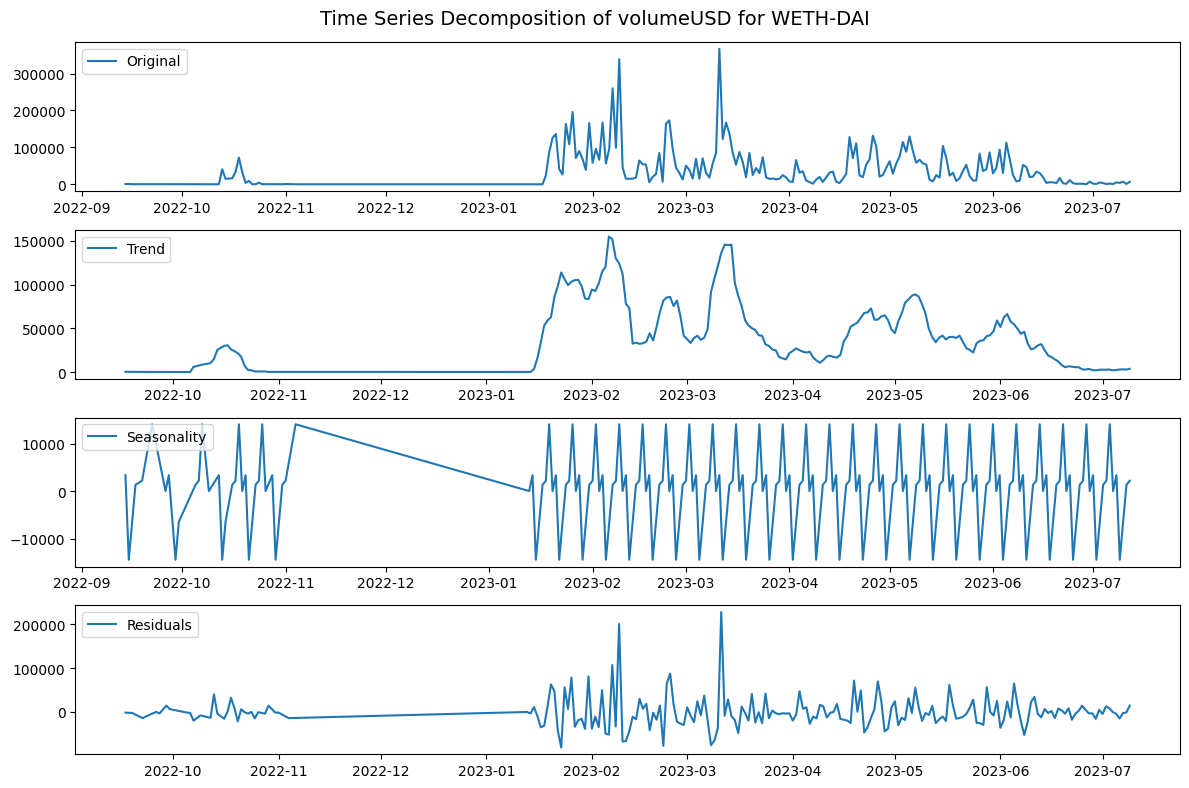

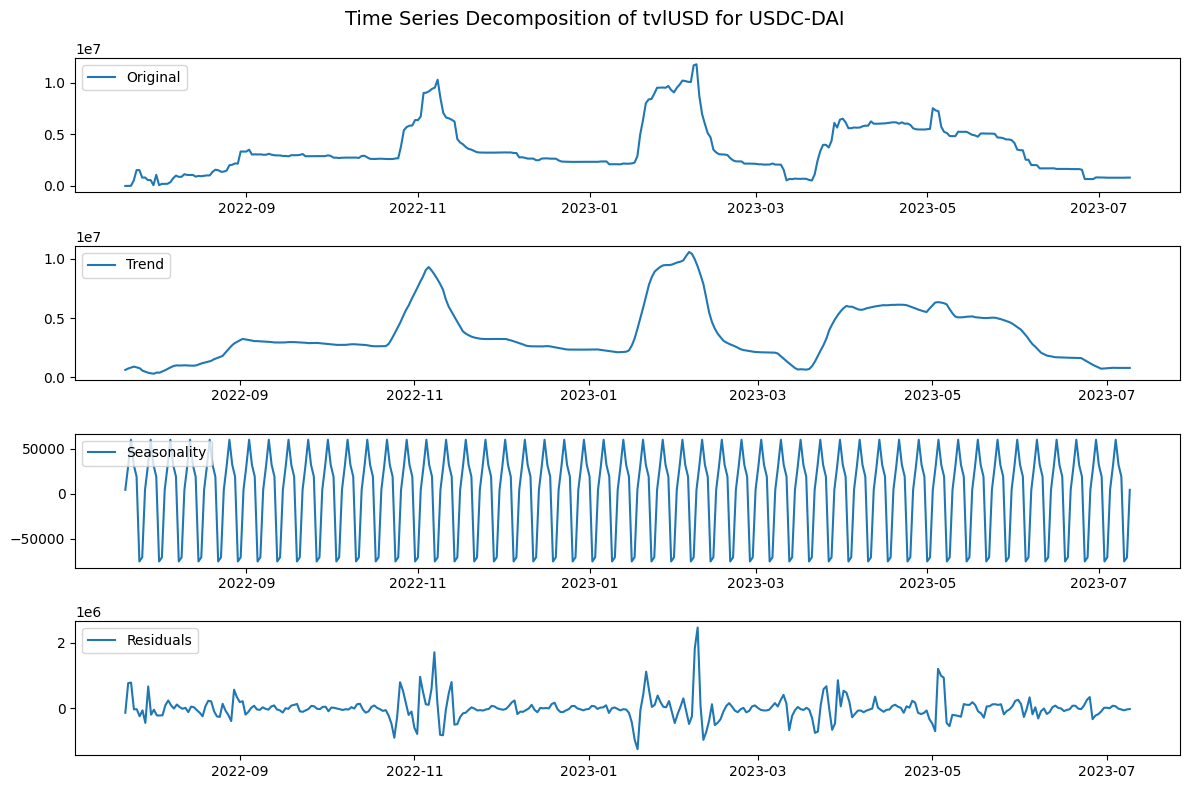

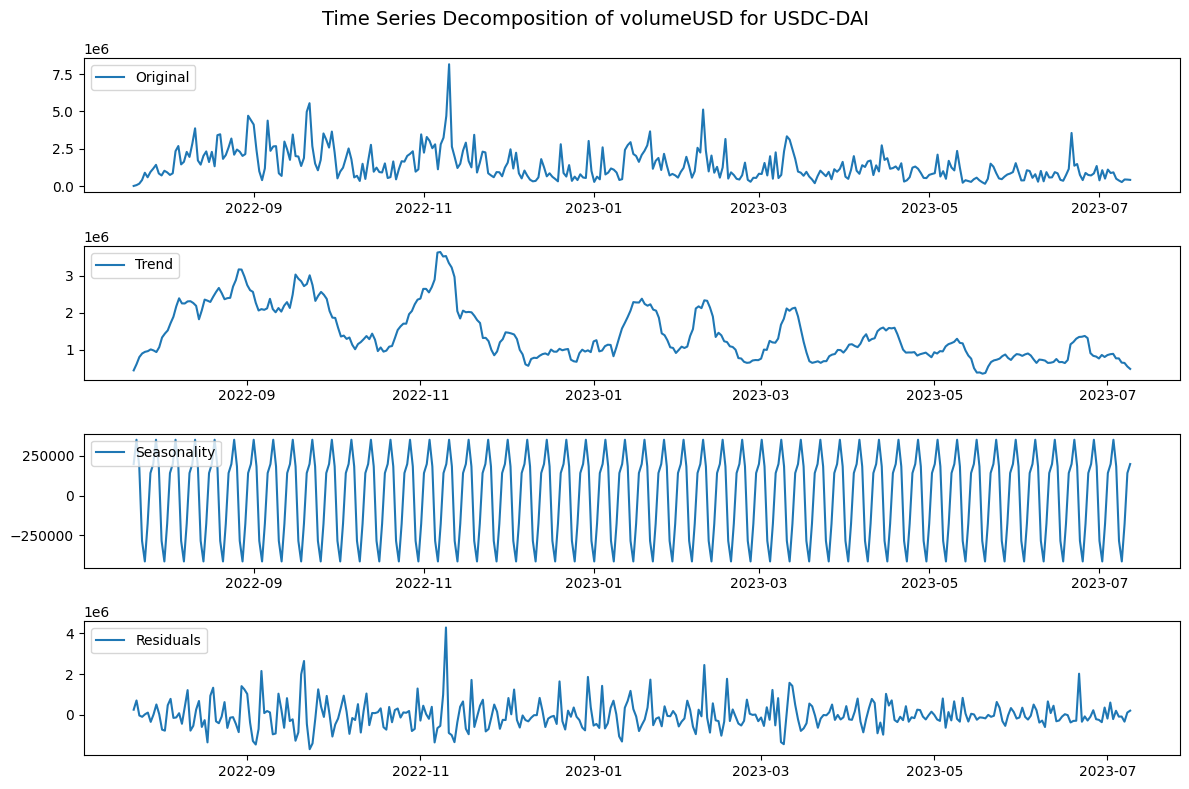

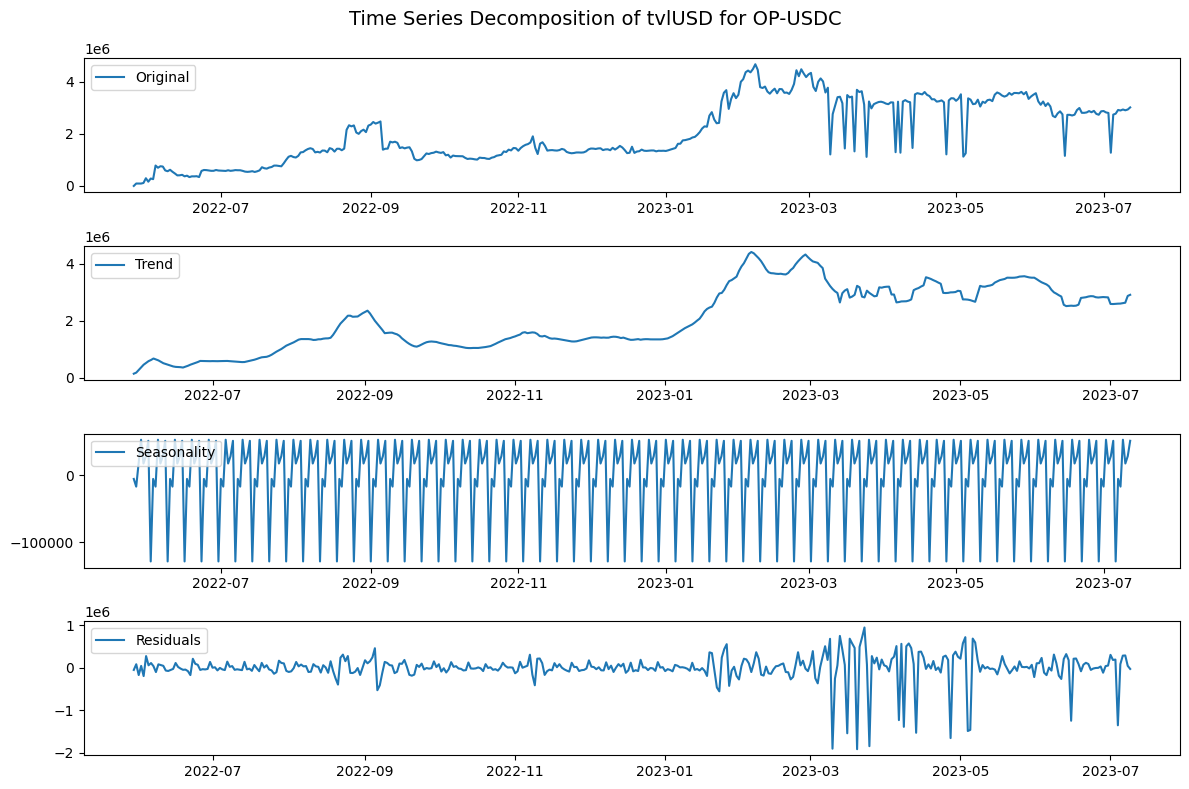

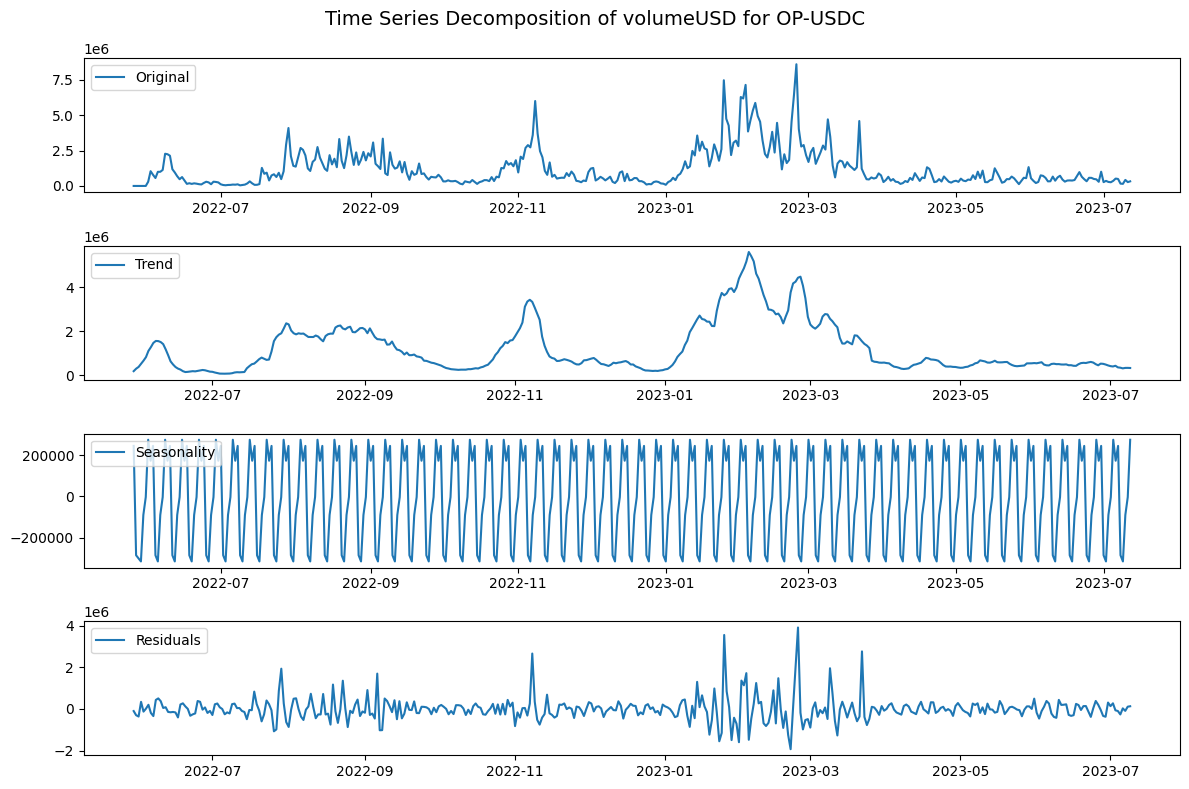

In [20]:
# Import necessary libraries for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to plot original time series, trend, seasonality and residuals
def plot_decomposition(data, metric, pool_name):
    # Decompose the time series
    decomposed = seasonal_decompose(data[metric], model='additive', period=7)  # weekly period

    # Plot the original data, the trend, the seasonality, and the residuals 
    plt.figure(figsize=(12,8))
    plt.suptitle(f'Time Series Decomposition of {metric} for {pool_name}', fontsize=14)
    
    plt.subplot(411)
    plt.plot(data['date'], data[metric], label='Original')
    plt.legend(loc='upper left')
    
    plt.subplot(412)
    plt.plot(data['date'], decomposed.trend, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(data['date'], decomposed.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(data['date'], decomposed.resid, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Perform time series decomposition for each pool
for data, pool_name in zip([data_treatment_wsteth_weth, data_treatment_weth_dai, data_treatment_usdc_dai, data_treatment_op_usdc],
                           ['wstETH-WETH', 'WETH-DAI', 'USDC-DAI', 'OP-USDC']):
    for metric in ['tvlUSD', 'volumeUSD']:
        plot_decomposition(data, metric, pool_name)


# Part 3: Further Explore dynamics of Liquidity Mining Programs
Here are a few possibilities for extending the analysis beyond what was covered in here:

1. **Multiple Treatment Groups:** Instead of having a single treatment group, we could consider multiple treatment groups that receive different levels or types of incentives. This would allow us to analyze the impact of different incentive structures on pool behavior.

2. **Long-Term Impact Analysis:** We could extend the timeframe of the analysis to better understand the long-term impacts of incentives. For example, do pools eventually return to their pre-incentive behavior, or do they maintain some of the gains even long after incentives have ended?

3. **Individual Behavior Analysis:** We could analyze individual behavior within the pools. For example, are there certain participants who contribute disproportionately to the increase in TVL or fees? If so, what characteristics do these participants have in common?

4. **Correlation with External Factors:** We could look at how external factors, such as overall market conditions or specific events, impact the effectiveness of incentives. For example, are incentives more effective during bull markets or bear markets?

5. **Alternative Metrics:** Instead of (or in addition to) TVL and fees, we could consider other metrics. For example, the number of active participants in a pool, the number of transactions, or the average transaction size.

6. **Prediction Modeling:** Based on the data, we could attempt to create a model to predict the impact of future incentive programs. This would involve feature engineering and machine learning.

7. **Comparing Different Protocols:** We could perform a comparative analysis between different DeFi protocols to understand how their incentive mechanisms differ and what the impact of these differences might be.
 